<a href="https://colab.research.google.com/github/JacksonGodbersen/ME592/blob/main/CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.9 MB/s eta 0:00:00


In [3]:
import gymnasium as gym
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import random

In [37]:
#Defines the structure of the nueral netwrok
class QNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_relu_stack = nn.Sequential(
nn.Linear(4, 128),
        nn.ReLU(),
nn.Linear(128, 128),
        nn.ReLU(),
nn.Linear(128, 128),
        nn.ReLU(),
nn.Linear(128, 2),

    )

  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

In [38]:
#Initializes the network and optimizer
Qnet = QNetwork()
optimizer = optim.Adam(Qnet.parameters(), lr=0.001)

In [39]:
#Creates a replay buffer. The replay buffer stores transtions for the agent to train on.
from collections import namedtuple, deque
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayBuffer(object):
  def __init__(self, capacity):
    self.memory = deque([], maxlen=capacity)

  def push(self, *args):
    self.memory.append(Transition(*args))

  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)

  def __len__(self):
    return len(self.memory)


In [40]:
def get_action(state):
  predicted_values = Qnet(torch.tensor(state))

  epsilon = .1 # Explore 10% of the time
  rand_val = random.random()

  if rand_val > epsilon:
    action = torch.argmax(predicted_values).item()
  else:
    action = torch.argmin(predicted_values).item()
  return action, predicted_values

In [45]:
#Does a foward pass through the NN and assigns the max q value in each set as the target value

gamma = .99
def get_target_value2(next_states, rewards):
    next_q_values = Qnet(next_states)

    next_q_values_max, _ = next_q_values.max(dim=1)

    #target_values = rewards + gamma * next_q_values_max
    target_values = next_q_values_max

    return target_values

In [42]:
#Computes the loss of a batch using MSE
def compute_loss2(predicted_values, target_values, actions):
    predicted_q_values = predicted_values.gather(1, actions.unsqueeze(1))

    loss = F.mse_loss(predicted_q_values, target_values.unsqueeze(1))

    return loss

In [46]:
env = gym.make("CartPole-v1")
observation, info = env.reset()

replay_memory = ReplayBuffer(capacity=10000)
batch_size = 32

reward_list = []
mean_list = []
for episode in range(1000):
  total_reward = 0
  while True:
    action, predicted_values = get_action(observation)
    next_observation, reward, terminated, truncated, info = env.step(action)

    replay_memory.push(observation, action, next_observation, reward)

    if len(replay_memory) >= batch_size:
      transitions = replay_memory.sample(batch_size)
      states, actions, next_states, rewards = zip(*transitions)
      states = torch.tensor(states, dtype=torch.float32)
      actions = torch.tensor(actions, dtype=torch.int64)
      next_states = torch.tensor(next_states, dtype=torch.float32)
      rewards = torch.tensor(rewards, dtype=torch.float32)

      predicted_values = Qnet(states)

      target_value = get_target_value2(next_states, rewards)
      loss = compute_loss2(predicted_values, target_value, actions)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    total_reward += reward

    if terminated or truncated:
        reward_list.append(total_reward)
        mean_list.append(sum(reward_list)/len(reward_list))

        observation, info = env.reset()
        break

In [12]:
import matplotlib.pyplot as plt

def plot_rewards(mean_list):
    plt.plot(range(len(mean_list)), mean_list)
    plt.xlabel('Episode')
    plt.ylabel('Mean Reward')
    plt.title('Mean Reward Plot')
    plt.grid(True)
    plt.show()

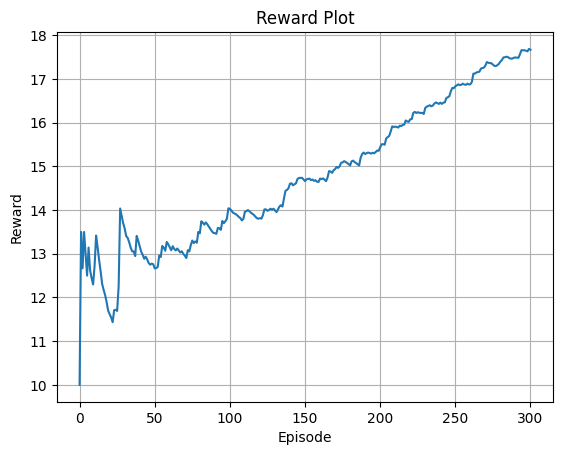

In [13]:
plot_rewards(mean_list)

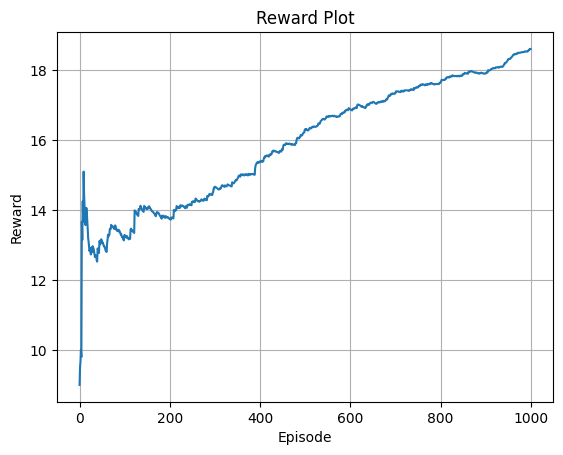

In [47]:
plot_rewards(mean_list)